# Section 5.5 — Hierarchical models

This notebook contains the code examples from [Section 5.5 Hierarchical models]() from the **No Bullshit Guide to Statistics**.

See also:
- [03_hierarchical_model.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/03_hierarchical_model.ipynb)
- [cs109b_lect13_bayes_2_2021.ipynb](./explorations/cs109b_lect13_bayes_2_2021.ipynb)
- https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section4-Hierarchical_Models.ipynb
- https://mc-stan.org/users/documentation/case-studies/radon_cmdstanpy_plotnine.html#data-prep
- https://github.com/mitzimorris/brms_feb_28_2023/blob/main/brms_notebook.Rmd
- https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
from ministats.utils import savefigure
DESTDIR = "figures/bayes/hierarchical"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################


In [4]:
# silence statsmodels kurtosistest warning when using n < 20
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Definitions

### Hierarchical (multilevel) models

### Model formula


## Radon dataset

https://bambinos.github.io/bambi/notebooks/radon_example.html

- Description: Contains measurements of radon levels in homes across various counties.
- Source: Featured in Andrew Gelman and Jennifer Hill's book Data Analysis Using Regression and Multilevel/Hierarchical Models.
- Application: Demonstrates partial pooling and varying intercepts/slopes in hierarchical modeling.


### Loading the data

In [5]:
radon = pd.read_csv("../datasets/radon.csv")
radon.shape

(919, 6)

In [6]:
radon.head()

,idnum,state,county,floor,log_radon,log_uranium
0,5081,MN,AITKIN,ground,0.788457,-0.689048
1,5082,MN,AITKIN,basement,0.788457,-0.689048
2,5083,MN,AITKIN,basement,1.064711,-0.689048
3,5084,MN,AITKIN,basement,0.000000,-0.689048
4,5085,MN,ANOKA,basement,1.131402,-0.847313


In [7]:
len(radon["county"].unique())

85

In [8]:
radon[["log_radon", "log_uranium"]].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
log_radon,919.0,1.22,0.85,-2.30,0.64,1.28,1.79,3.88
log_uranium,919.0,-0.13,0.37,-0.88,-0.47,-0.10,0.18,0.53


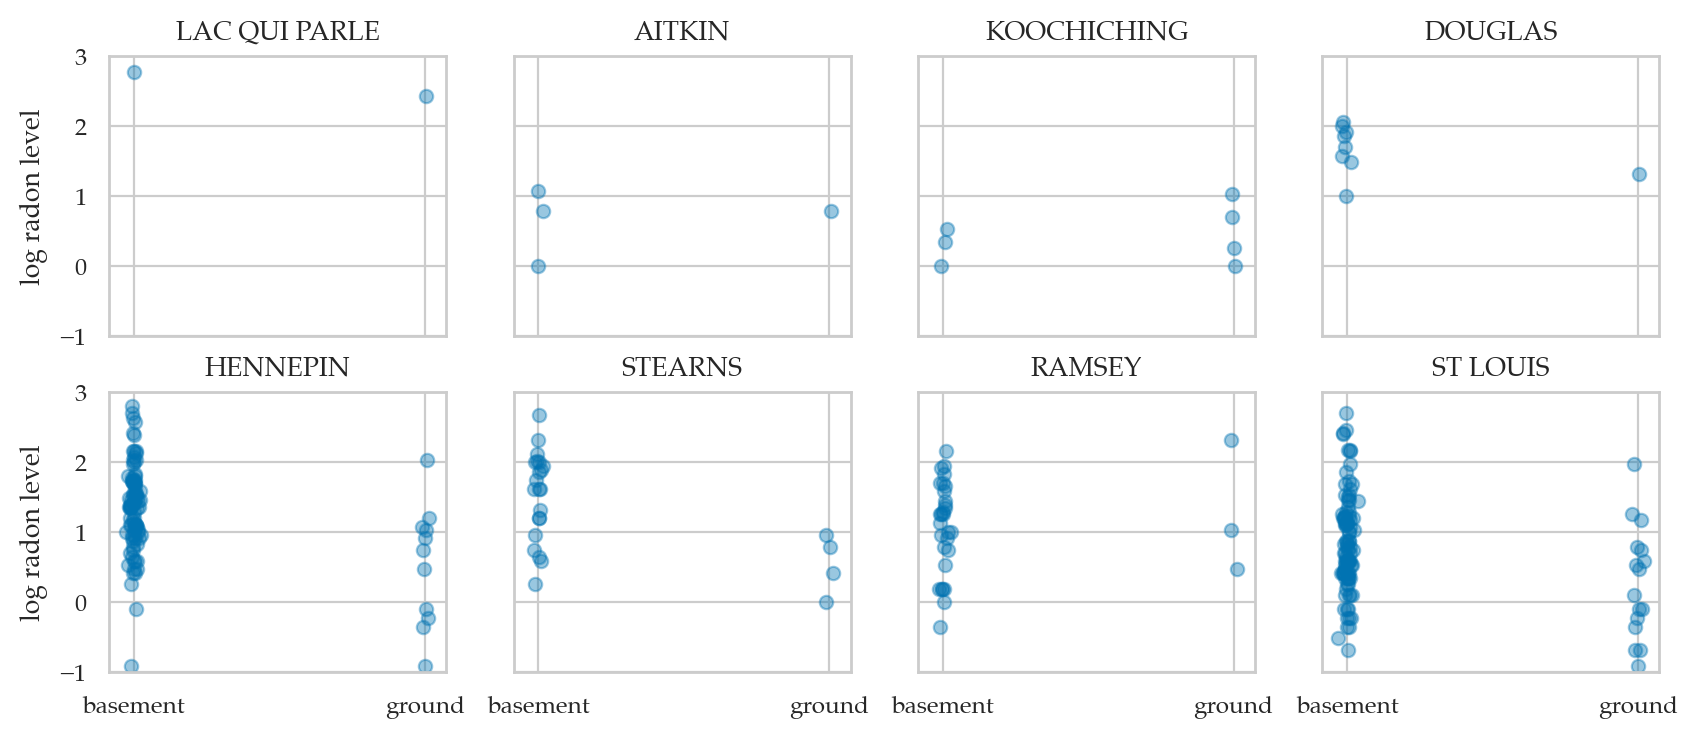

In [9]:
#######################################################
from ministats.book.figures import plot_counties
sel_counties = [
  "LAC QUI PARLE", "AITKIN", "KOOCHICHING", "DOUGLAS",
  "HENNEPIN", "STEARNS", "RAMSEY", "ST LOUIS",
]
plot_counties(radon, counties=sel_counties);

In [10]:
# # FIGURES ONLY
# sel_counties = [
#   "LAC QUI PARLE", "AITKIN", "KOOCHICHING", "DOUGLAS",
#   "HENNEPIN", "STEARNS", "RAMSEY", "ST LOUIS",
# ]
# fig = plot_counties(radon, counties=sel_counties, figsize=(7,3.2))
# filename = os.path.join(DESTDIR, "sel_counties_scatter_only.pdf")
# savefigure(fig, filename)

## Example 1: complete pooling model

= common linear regression model for all counties

### Bayesian model


We can  pool all the data and estimate one big regression to asses the influence of the floor variable
on radon levels across all counties.

$$
  Y = \beta_0 + \beta_x \cdot x.
$$

The variable $x$ corresponds to the `floor` column,
with $0$ representing basement, and $1$ representing ground floor.

By ignoring the county feature, we do not differenciate on counties.

### Bambi model


In [11]:
import bambi as bmb

priors1 = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=2),
    "floor": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
}

mod1 = bmb.Model(formula="log_radon ~ 1 + floor",
                 family="gaussian",
                 link="identity",
                 priors=priors1,
                 data=radon)
mod1

       Formula: log_radon ~ 1 + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 2.0)
            floor ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0)

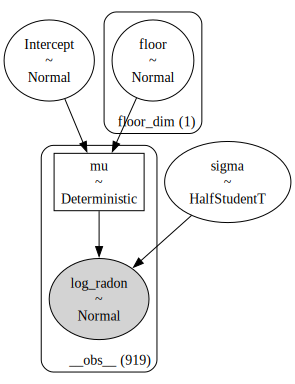

In [12]:
mod1.build()
mod1.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example1_complete_pooling_mod1_graph")
# mod1.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [13]:
idata1 = mod1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [14]:
import arviz as az

az.summary(idata1, kind="stats")

                mean     sd  hdi_3%  hdi_97%
Intercept      1.327  0.029   1.272    1.380
floor[ground] -0.614  0.072  -0.747   -0.479
sigma          0.824  0.019   0.790    0.858


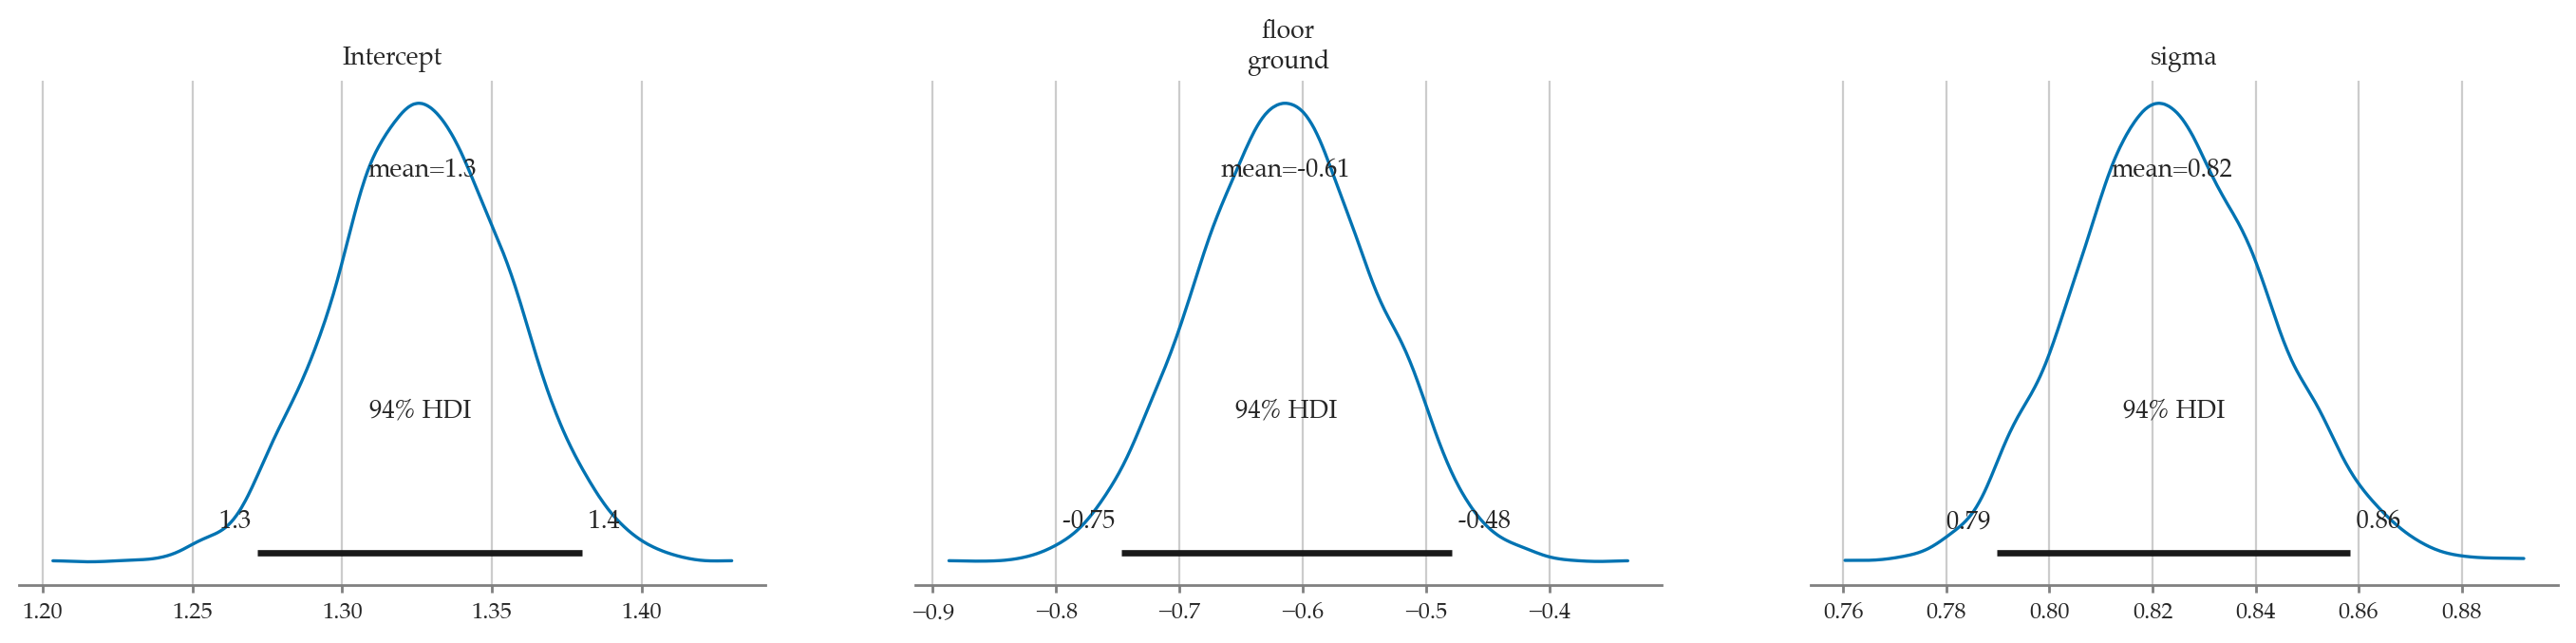

In [15]:
az.plot_posterior(idata1);

In [16]:
# # FIGURES ONLY
# az.plot_posterior(idata1, round_to=2, figsize=(6,1.8));
# filename = os.path.join(DESTDIR, "example1_posterior.pdf")
# savefigure(plt.gcf(), filename)

Default computed for conditional variable: floor


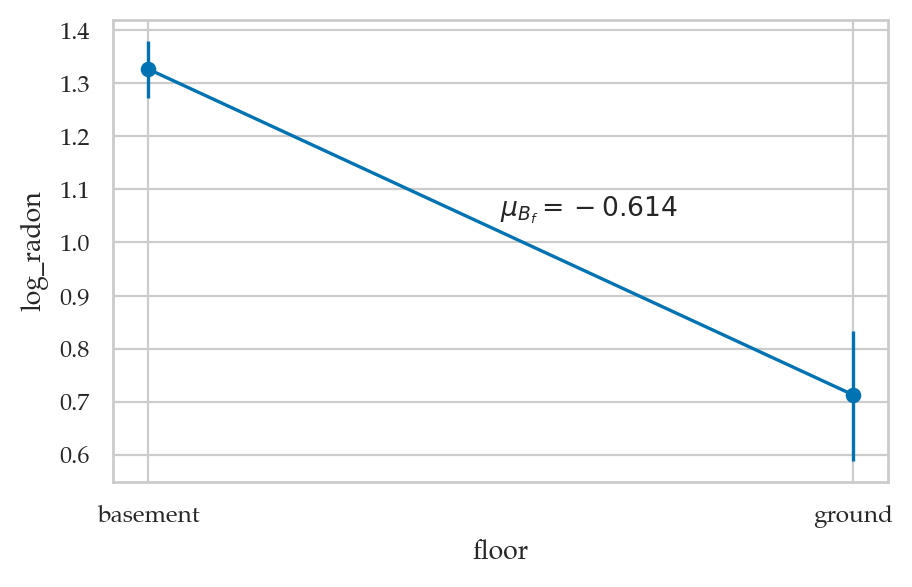

In [17]:
fig, axs = bmb.interpret.plot_predictions(mod1, idata1, conditional="floor")

means1 = az.summary(idata1, kind="stats")["mean"]
y0 = means1["Intercept"]
y1 = means1["Intercept"] + means1["floor[ground]"]
sns.lineplot(x=[0,1], y=[y0,y1], ax=axs[0]);

midpoint = [0.5, (y0+y1)/2 + 0.03]
slope = means1["floor[ground]"].round(3)
axs[0].annotate("$\\mu_{B_{f}}=%.3f$" % slope, midpoint);

In [18]:
# # FIGURES ONLY
# fig, axs = bmb.interpret.plot_predictions(mod1, idata1, conditional="floor",
#                                           fig_kwargs={"figsize":(3,2)})
# means1 = az.summary(idata1, kind="stats")["mean"]
# y0 = means1["Intercept"]
# y1 = means1["Intercept"] + means1["floor[ground]"]
# sns.lineplot(x=[0,1], y=[y0,y1], ax=axs[0]);
# midpoint = [0.5, (y0+y1)/2 + 0.03]
# slope = means1["floor[ground]"].round(3)
# axs[0].annotate("$\\mu_{B_{f}}=%.3f$" % slope, midpoint);
# filename = os.path.join(DESTDIR, "example1_basement_ground_slope.pdf")
# savefigure(plt.gcf(), filename)

### Conclusion

not using group membership, so we have lots of bias


## Example 2: no pooling model

= separate intercept for each county 

### Bayesian model

If we treat different counties as independent,
so each one gets an intercept term:

$$
  Y_j = \beta_{0j} + \beta_{x} x.
$$

### Bambi model


In [19]:
priors2 = {
    "county": bmb.Prior("Normal", mu=0, sigma=10),
    "floor": bmb.Prior("Normal", mu=0, sigma=30),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
}

mod2 = bmb.Model("log_radon ~ 0 + county + floor",
                 family="gaussian",
                 link="identity",
                 priors=priors2,
                 data=radon)
mod2

       Formula: log_radon ~ 0 + county + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            county ~ Normal(mu: 0.0, sigma: 10.0)
            floor ~ Normal(mu: 0.0, sigma: 30.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0)

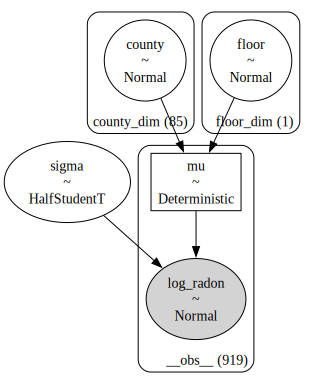

In [20]:
mod2.build()
mod2.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example2_no_pooling_mod2_graph")
# mod2.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [21]:
idata2 = mod2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, county, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [22]:
idata2sel = idata2.sel(county_dim=sel_counties)
az.summary(idata2sel, kind="stats")

,mean,sd,hdi_3%,hdi_97%
county[LAC QUI PARLE],2.951,0.528,1.948,3.930
county[AITKIN],0.842,0.382,0.113,1.534
county[KOOCHICHING],0.822,0.287,0.277,1.344
county[DOUGLAS],1.736,0.250,1.268,2.214
county[HENNEPIN],1.360,0.074,1.223,1.495
county[STEARNS],1.491,0.150,1.225,1.787
county[RAMSEY],1.159,0.136,0.915,1.426
county[ST LOUIS],0.868,0.072,0.736,0.999
floor[ground],-0.719,0.075,-0.862,-0.579
sigma,0.757,0.019,0.723,0.792


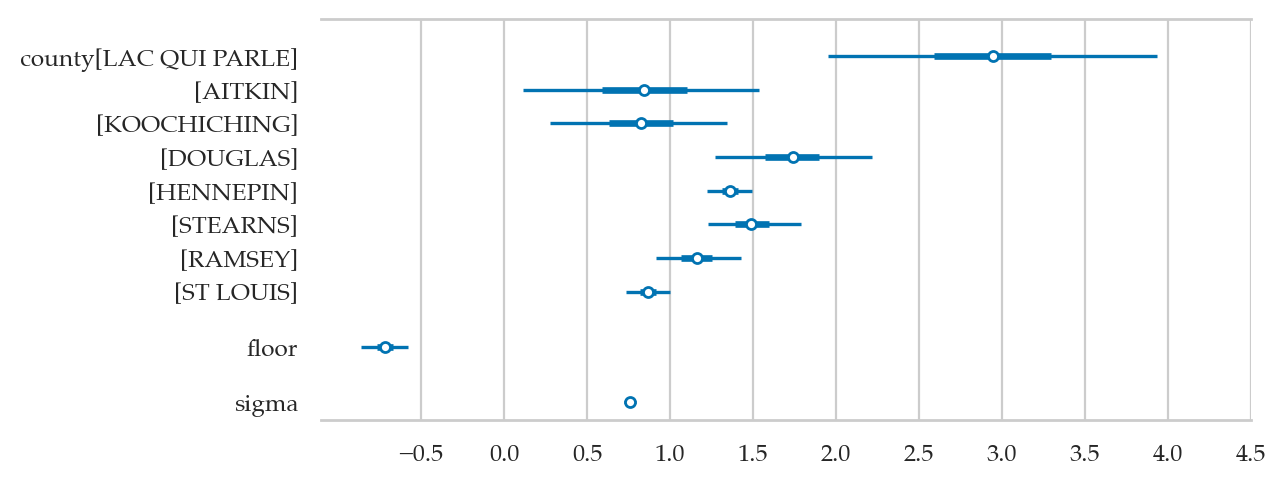

In [23]:
axs = az.plot_forest(idata2sel, combined=True, figsize=(6,2.6))
axs[0].set_xticks(np.arange(-0.5,4.6,0.5))
axs[0].set_title(None);

In [24]:
# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "forest_plot_mod2_sel_counties.pdf")
# savefigure(axs[0], filename)

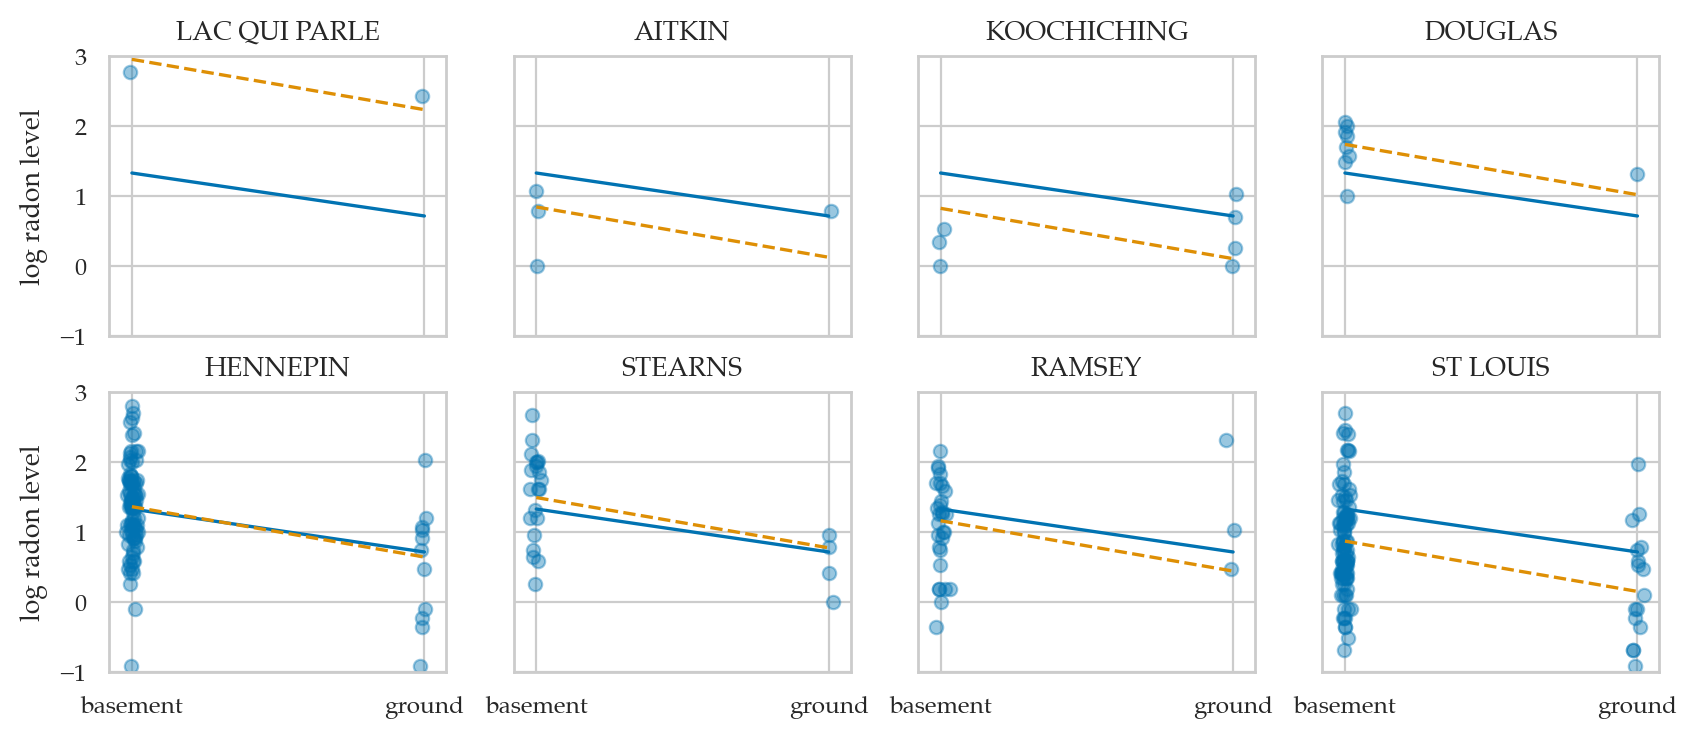

In [25]:
plot_counties(radon, idata_cp=idata1, idata_np=idata2);

In [26]:
# # FIGURES ONLY
# sel_counties = [
#   "LAC QUI PARLE", "AITKIN", "KOOCHICHING", "DOUGLAS",
#   "HENNEPIN", "STEARNS", "RAMSEY", "ST LOUIS",
# ]
# fig = plot_counties(radon, idata_cp=idata1, idata_np=idata2,
#                     counties=sel_counties, figsize=(7,3.2))
# filename = os.path.join(DESTDIR, "sel_counties_complete_and_no_pooling.pdf")
# savefigure(fig, filename)

In [27]:
# fig, axs = bmb.interpret.plot_predictions(mod2, idata2, ["floor", "county"]);
# axs[0].get_legend().remove()

In [28]:
# post2 = idata2["posterior"]
# unpooled_means = post2.mean(dim=("chain", "draw"))
# unpooled_hdi = az.hdi(idata2)

# unpooled_means_iter = unpooled_means.sortby("county")
# unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.county)

# _, ax = plt.subplots(figsize=(12, 5))
# unpooled_means_iter.plot.scatter(x="county_dim", y="county", ax=ax, alpha=0.9)
# ax.vlines(
#     np.arange(len(radon["county"].unique())),
#     unpooled_hdi_iter.county.sel(hdi="lower"),
#     unpooled_hdi_iter.county.sel(hdi="higher"),
#     color="orange",
#     alpha=0.6,
# )
# ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
# ax.tick_params(rotation=90);

### Conclusion
treating each group independently, so we have lots of variance


## Example 3: hierarchical model

= partial pooling model
= varying intercepts model

### Bayesian hierarchical model

\begin{align*}
Y_j      \;\; &\sim \;\; \mathcal{N}(B_0 + B_j + B_x x, \, \Sigma_Y),  \\
B_0      \;\; &\sim \;\; \mathcal{N}(\mu_{B_0},\sigma_{B_0}), \\
B_x      \;\; &\sim \;\; \mathcal{N}(\mu_{B_J},\sigma_{B_x}), \\
B_j      \;\; &\sim \;\; \mathcal{N}(0,\Sigma_{B_j}), \\
\Sigma_Y \;\; &\sim \;\;  \mathcal{T}^+(\nu=4, \sigma=?), \\
\Sigma_{B_j} \;\; &\sim \;\;  \mathcal{T}^+(\nu=4, \sigma=?).
\end{align*}


The partial pooling formula estimates per-county intercepts which drawn
from the same distribution which is estimated jointly with the rest of
the model parameters. The `1` is the intercept co-efficient. The
estimates across counties will all have the same slope.


    log_radon ~ 1 + (1|county_id) + floor


There is a middle ground to both of these extremes.
Specifically, we may assume that the intercepts are different for each county as in the unpooled case,
but they are drawn from the same distribution.
The different counties are effectively sharing information through the common prior.


NOTE: some counties have very few sample; the hierarchical model will provide "shrinkage" for these groups, and use global information learned from all counties

In [29]:
radon["log_radon"].describe()

count    919.000000
mean       1.224623
std        0.853327
min       -2.302585
25%        0.641854
50%        1.280934
75%        1.791759
max        3.875359
Name: log_radon, dtype: float64

In [30]:
radon.groupby("floor")["log_radon"].describe()

,count,mean,std,min,25%,50%,75%,max
floor,,,,,,,,
basement,766.0,1.326744,0.782709,-2.302585,0.788457,1.360977,1.883253,3.875359
ground,153.0,0.713349,0.999376,-2.302585,0.095310,0.741937,1.308333,3.234749


### Bambi model

In [31]:
priors3 = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=2),
    "floor": bmb.Prior("Normal", mu=0, sigma=5),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    # "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2)),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
    # "sigma": bmb.Prior("Exponential", lam=1),
    # "sigma": bmb.Prior("HalfNormal", sigma=10), # from PyStan tutorial
    # "sigma": bmb.Prior("Uniform", lower=0, upper=100), # from PyMC example
}

formula3 = "log_radon ~ 1 + (1|county) + floor"
#######################################################
mod3 = bmb.Model(formula=formula3,
                 family="gaussian",
                 link="identity",
                 priors=priors3,
                 data=radon,
                 noncentered=False)

mod3

       Formula: log_radon ~ 1 + (1|county) + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 2.0)
            floor ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0)

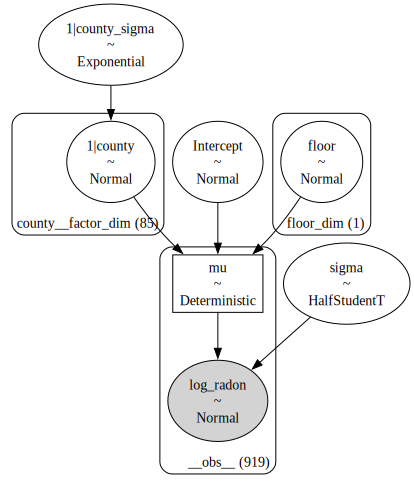

In [32]:
mod3.build()
mod3.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example3_partial_pooling_mod3_graph")
# mod3.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [33]:
idata3 = mod3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor, 1|county_sigma, 1|county]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


The group level parameters

In [34]:
idata3sel = idata3.sel(county__factor_dim=sel_counties)
az.summary(idata3sel, kind="stats")

                          mean     sd  hdi_3%  hdi_97%
1|county[LAC QUI PARLE]  0.417  0.298  -0.154    0.983
1|county[AITKIN]        -0.270  0.255  -0.730    0.238
1|county[KOOCHICHING]   -0.384  0.224  -0.820    0.034
1|county[DOUGLAS]        0.168  0.204  -0.225    0.539
1|county[HENNEPIN]      -0.098  0.083  -0.250    0.059
1|county[STEARNS]        0.019  0.141  -0.254    0.271
1|county[RAMSEY]        -0.263  0.130  -0.489   -0.003
1|county[ST LOUIS]      -0.573  0.086  -0.727   -0.404
1|county_sigma           0.336  0.045   0.252    0.421
Intercept                1.461  0.052   1.364    1.557
floor[ground]           -0.694  0.070  -0.826   -0.567
sigma                    0.756  0.018   0.722    0.790


The intercept offsets for each county are:

In [35]:
# sum( idata3["posterior"]["1|county"].stack(sample=("chain","draw")).values.mean(axis=1) )

In [36]:
# az.plot_forest(idata3, combined=True, figsize=(7,2),
#                var_names=["Intercept", "floor", "1|county_sigma", "sigma"]);

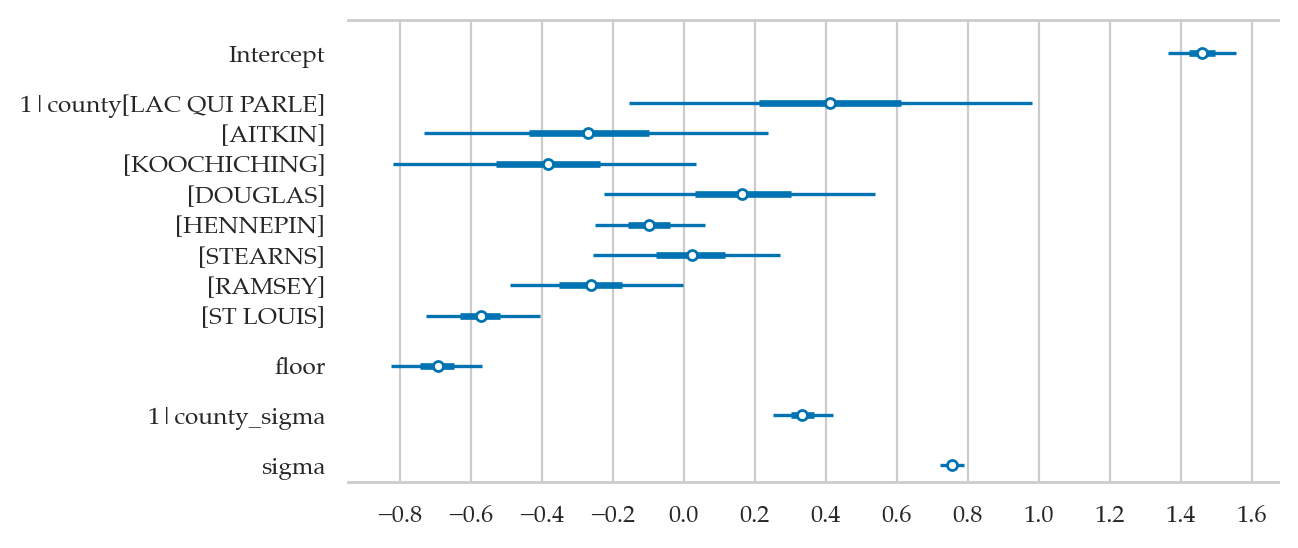

In [37]:
#######################################################
axs = az.plot_forest(idata3sel, var_names=["Intercept", "1|county", "floor", "1|county_sigma", "sigma"], combined=True, figsize=(6,3))
# axs = az.plot_forest(idata3sel, combined=True, figsize=(6,3))
axs[0].set_xticks(np.arange(-0.8,1.6,0.2))
axs[0].set_title(None);

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "forest_plot_mod3_sel_counties.pdf")
# savefigure(plt.gcf(), filename)

In [38]:
# az.plot_forest(idata3, var_names=["1|county"], combined=True);

### Compare models

Compare complete pooling,  no pooling, and partial pooling models


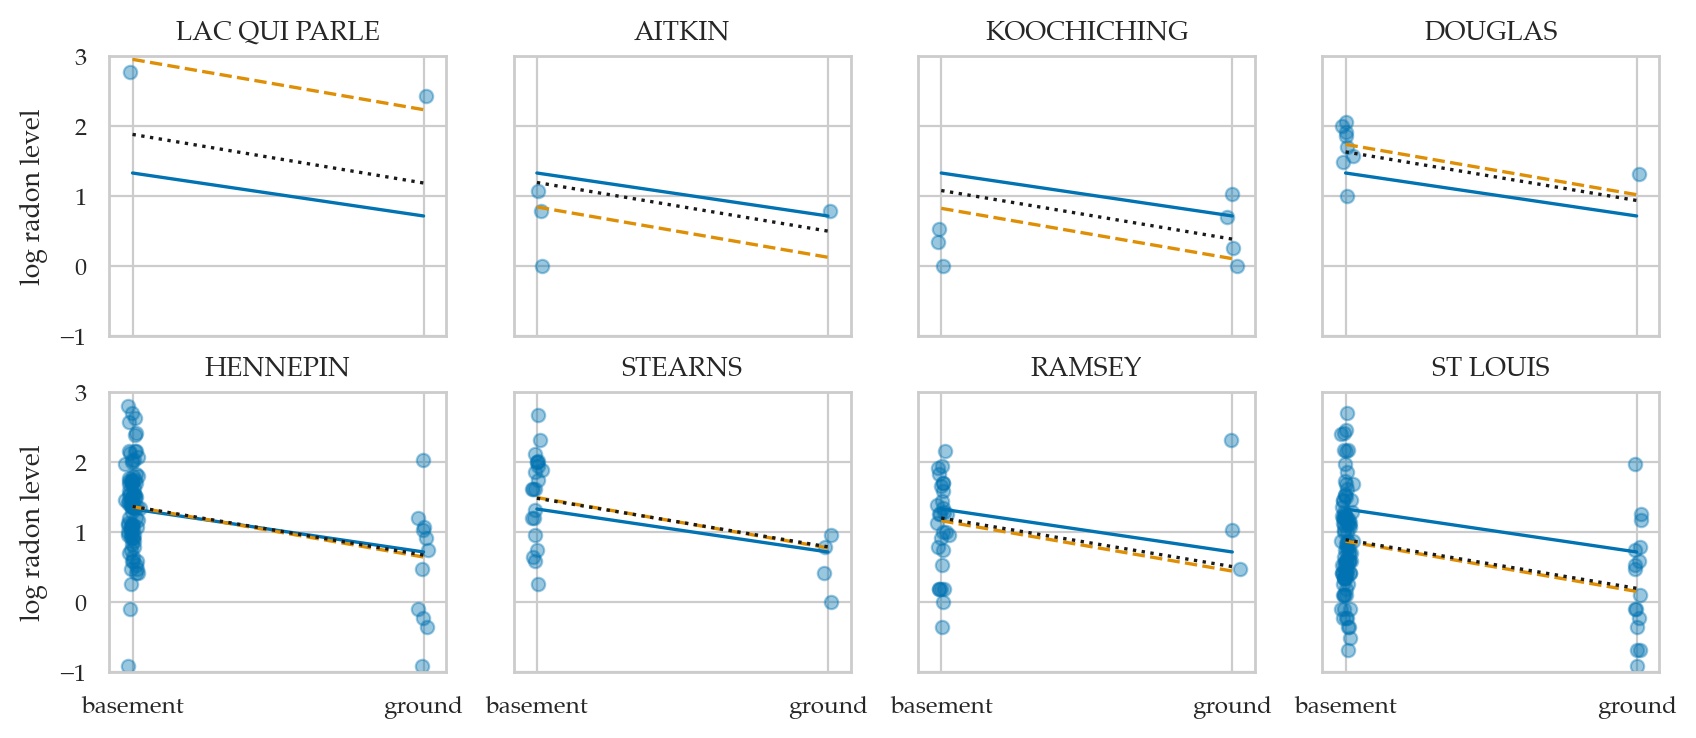

In [39]:
plot_counties(radon, idata_cp=idata1, idata_np=idata2, idata_pp=idata3);

In [40]:
# # FIGURES ONLY
# fig = plot_counties(radon, idata_cp=idata1, idata_np=idata2, idata_pp=idata3, figsize=(7,3.2))
# filename = os.path.join(DESTDIR, "sel_counties_all_models.pdf")
# savefigure(fig, filename)

### Conclusions

## Explanations

### Prior selection for hierarchical models

?


### Varying intercepts and slopes model

= Group-specific slopes
We can also make beta_x group-specific


The varying-slope, varying intercept model adds `floor` to the
group-level co-efficients. Now estimates across counties will all have
varying slope.

    log_radon ~ floor + (1 + floor | county_id)

In [41]:
#######################################################
formula4 = "log_radon ~ (1 + floor | county)"

priors4 = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=2),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "floor|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
}

mod4 = bmb.Model(formula=formula4,
                 family="gaussian",
                 link="identity",
                 priors=priors4,
                 data=radon,
                 noncentered=False)
mod4

       Formula: log_radon ~ (1 + floor | county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 2.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
            floor|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0)

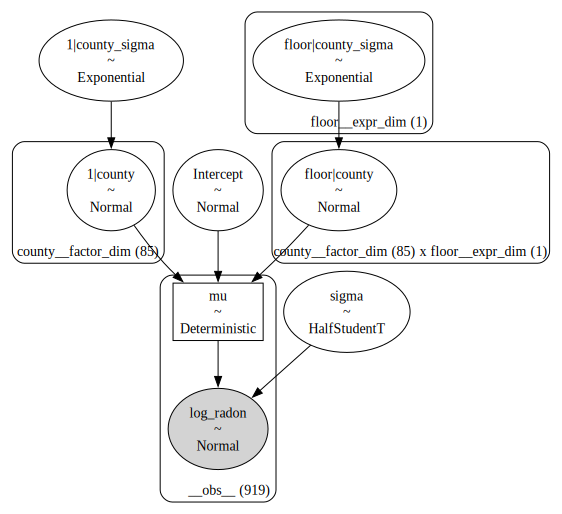

In [42]:
mod4.build()
mod4.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "varying_int_and_slopes_mod4_graph")
# mod4.graph(name=filename, fmt="png", dpi=300)

In [43]:
idata4 = mod4.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|county_sigma, 1|county, floor|county_sigma, floor|county]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [44]:
az.autocorr(idata4["posterior"]["sigma"].values.flatten())[0:10]

array([ 1.        , -0.24283056,  0.10516607, -0.01097018,  0.02797382,
       -0.04739507,  0.01376438,  0.01053998, -0.01090816,  0.01865162])

In [45]:
az.summary(idata4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|county[AITKIN],-0.306,0.267,-0.809,0.192,0.003,0.003,6498.0,3183.0,1.0
1|county[ANOKA],-0.469,0.115,-0.679,-0.247,0.002,0.001,4526.0,3011.0,1.0
1|county[BECKER],-0.046,0.287,-0.574,0.523,0.003,0.005,7554.0,2735.0,1.0
1|county[BELTRAMI],0.031,0.247,-0.423,0.487,0.003,0.004,6509.0,3298.0,1.0
1|county[BENTON],-0.047,0.250,-0.513,0.426,0.003,0.004,7910.0,3246.0,1.0
...,...,...,...,...,...,...,...,...,...
"floor|county[ground, WINONA]",-1.330,0.415,-2.119,-0.572,0.006,0.004,4837.0,2849.0,1.0
"floor|county[ground, WRIGHT]",-0.348,0.533,-1.322,0.665,0.006,0.009,7290.0,2600.0,1.0
"floor|county[ground, YELLOW MEDICINE]",-0.011,0.712,-1.352,1.297,0.008,0.014,8110.0,2605.0,1.0
floor|county_sigma[ground],0.731,0.108,0.542,0.938,0.003,0.002,1145.0,1960.0,1.0


In [46]:
# idata4["posterior"]

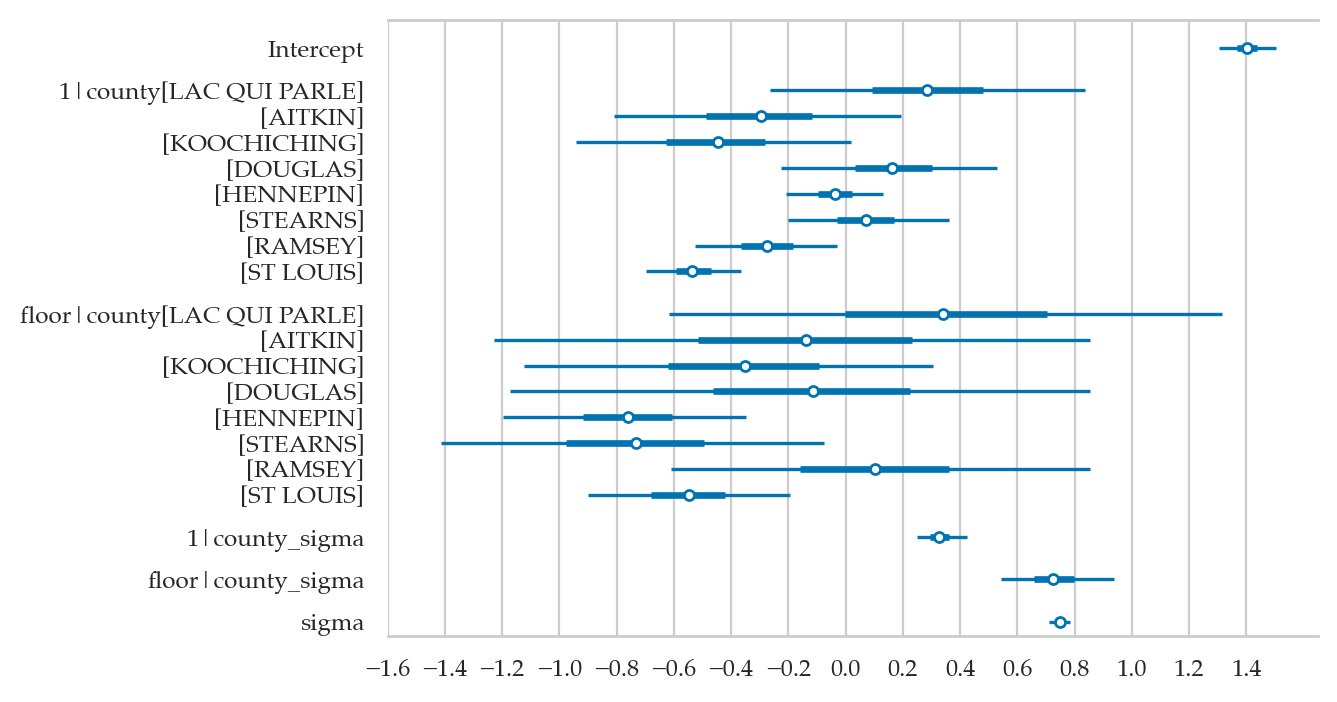

In [47]:
idata4sel = idata4.sel(county__factor_dim=sel_counties)
var_names = ["Intercept",
             "1|county",
             "floor|county",
             "1|county_sigma",
             "floor|county_sigma",
             "sigma"]
axs = az.plot_forest(idata4sel, combined=True, var_names=var_names, figsize=(6,4))
axs[0].set_xticks(np.arange(-1.6,1.6,0.2))
axs[0].set_title(None);

# FIGURES ONLY
# filename = os.path.join(DESTDIR, "forest_plot_mod4_sel_counties.pdf")
# savefigure(plt.gcf(), filename)

### Comparing models

In [48]:
idata1 = mod1.fit(idata_kwargs={"log_likelihood": True})
idata2 = mod2.fit(idata_kwargs={"log_likelihood": True})
idata3 = mod3.fit(idata_kwargs={"log_likelihood": True})
idata4 = mod4.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, county, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor, 1|county_sigma, 1|county]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|county_sigma, 1|county, floor|county_sigma, floor|county]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Compare models based on their expected log pointwise predictive density (ELPD).

The ELPD is estimated either by Pareto smoothed importance sampling leave-one-out cross-validation (LOO) or using the widely applicable information criterion (WAIC). We recommend loo. Read more theory here - in a paper by some of the leading authorities on model comparison dx.doi.org/10.1111/1467-9868.00353

In [49]:
radon_models = {
    "mod1 (complete pooling)": idata1,
    "mod2 (no pooling)": idata2,
    "mod3 (varying intercepts)": idata3,
    "mod4 (varying int. and slopes)": idata4,
}
compare_results = az.compare(radon_models)
compare_results

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mod3 (varying intercepts),0,-1073.936395,49.371251,0.000000,0.706514,28.132650,0.000000,False,log
mod4 (varying int. and slopes),1,-1087.710666,87.048381,13.774271,0.218410,29.939037,7.305989,True,log
mod2 (no pooling),2,-1099.989024,86.893754,26.052628,0.000000,28.317720,6.311947,True,log
mod1 (complete pooling),3,-1126.915450,3.771881,52.979054,0.075075,25.539769,10.622681,False,log


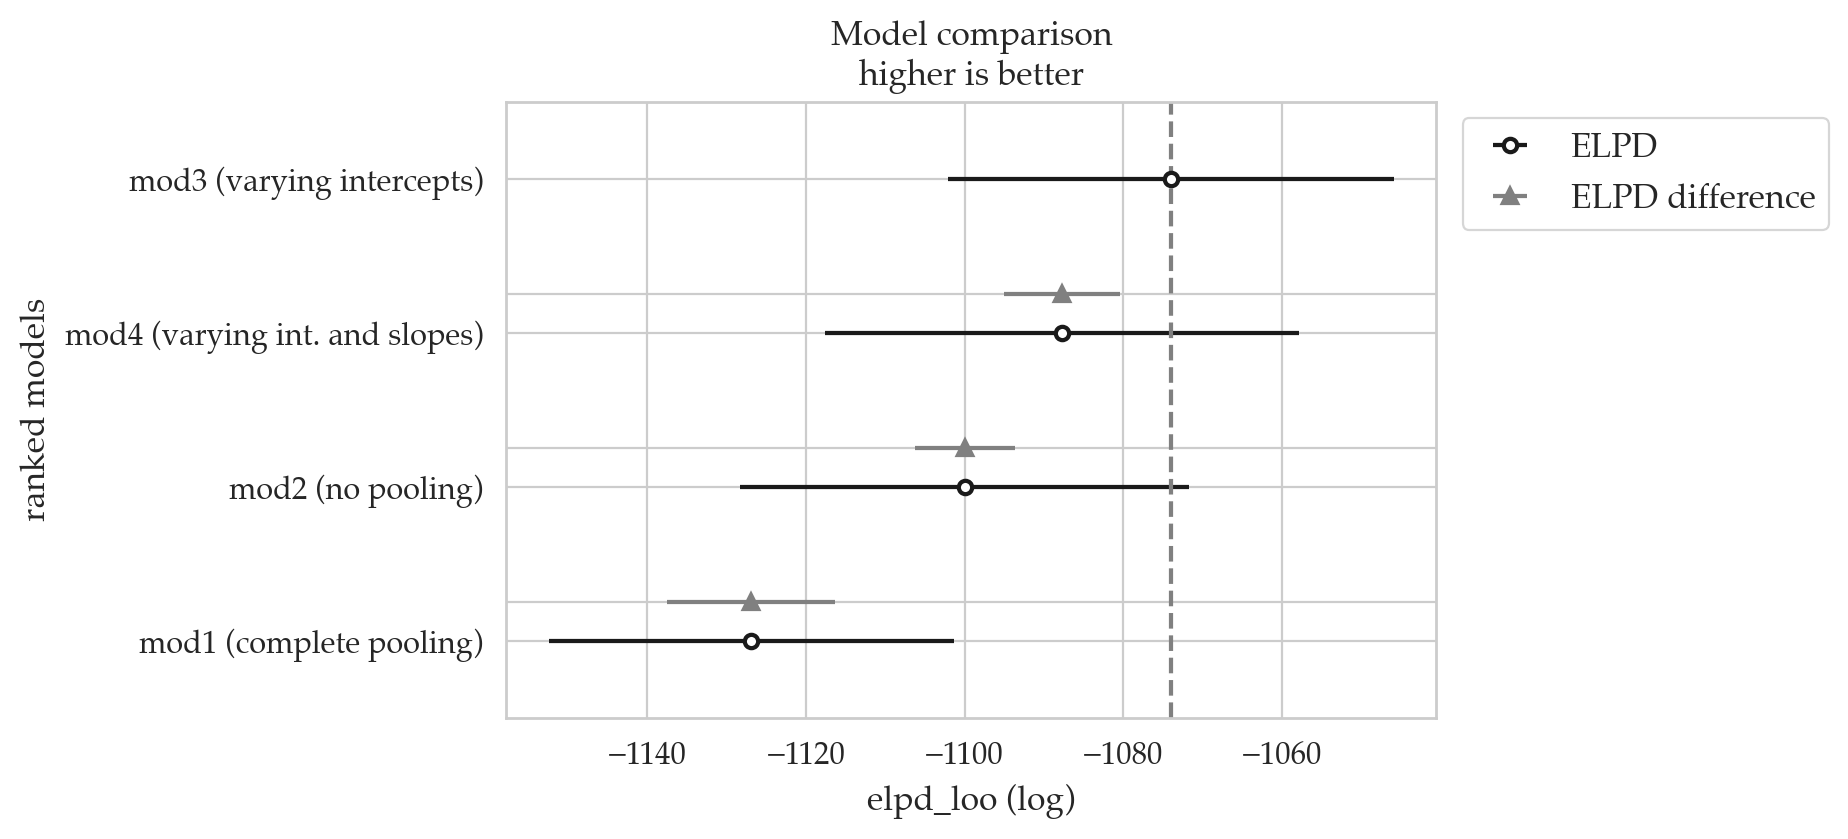

In [50]:
az.plot_compare(compare_results);

# # FIGURES ONLY
# ax = az.plot_compare(compare_results, figsize=(9,3))
# ax.set_title(None)
# filename = os.path.join(DESTDIR, "model_comparison_mod1_mod2_mod3_mod4.pdf")
# savefigure(ax, filename)

#### ELPD and elpd_loo

The ELPD is the theoretical expected log pointwise predictive density for a new dataset (Eq 1 in VGG2017), which can be estimated, e.g., using cross-validation. elpd_loo is the Bayesian LOO estimate of the expected log pointwise predictive density (Eq 4 in VGG2017) and is a sum of N individual pointwise log predictive densities. Probability densities can be smaller or larger than 1, and thus log predictive densities can be negative or positive. For simplicity the ELPD acronym is used also for expected log pointwise predictive probabilities for discrete models. Probabilities are always equal or less than 1, and thus log predictive probabilities are 0 or negative.

via https://mc-stan.org/loo/reference/loo-glossary.html

### Frequentist multilevel models

We can use `statsmodels` to fit multilevel models too.

#### Varying intercepts model using `statsmodels`

In [51]:
import statsmodels.formula.api as smf
sm3 = smf.mixedlm("log_radon ~ 0 + floor",   # Fixed effects (no intercept and floor as a fixed effect)
                  groups="county",           # Grouping variable for random effects
                  re_formula="1",            # Random effects = intercept
                  data=radon)
res3 = sm3.fit()
res3.summary().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
floor[basement],1.462,0.052,28.164,0.000,1.360,1.563
floor[ground],0.769,0.074,10.339,0.000,0.623,0.914
county Var,0.108,0.041,,,,


In [52]:
# slope
res3.params["floor[ground]"] - res3.params["floor[basement]"]

-0.6929937406558043

In [53]:
# sigma-hat
np.sqrt(res3.scale)

0.7555891484188184

In [54]:
# standard deviation of the variability among county-specific Intercepts
np.sqrt(res3.cov_re.values)

array([[0.32822242]])

In [55]:
# intercept for first country in res3 
res3.random_effects["AITKIN"].values

array([-0.27009756])

This is very close to the mean of the random effect coefficient for `AITKIN` in the Bayesian model `mod3` which was $-0.268$.

#### Varying intercepts and slopes model using `statsmodels`

In [56]:
sm4 = smf.mixedlm("log_radon ~ 0 + floor",   # Fixed effects (no intercept and floor as a fixed effect)
                  groups="county",           # Grouping variable for random effects
                  re_formula="1 + floor",    # Random effects: 1 for intercept, floor for slope
                  data=radon)
res4 = sm4.fit()
res4.summary().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
floor[basement],1.463,0.054,26.977,0.000,1.356,1.569
floor[ground],0.782,0.085,9.208,0.000,0.615,0.948
county Var,0.122,0.049,,,,
county x floor[T.ground] Cov,-0.040,0.057,,,,
floor[T.ground] Var,0.118,0.120,,,,


In [57]:
# slope estimate
res4.params["floor[ground]"] - res4.params["floor[basement]"]

-0.6810977572101944

In [58]:
# sigma-hat
np.sqrt(res4.scale)

0.7461559982563548

In [59]:
# standard deviation of the variability among county-specific Intercepts
county_var_int = res4.cov_re.loc["county", "county"]
np.sqrt(county_var_int)

0.3486722110725776

In [60]:
# standard deviation of the variability among county-specific slopes
county_var_slopes = res4.cov_re.loc["floor[T.ground]", "floor[T.ground]"]
np.sqrt(county_var_slopes)

0.3435539748320278

In [61]:
# correlation between Intercept and slope group-level coefficients
county_floor_cov = res4.cov_re.loc["county", "floor[T.ground]"]
county_floor_cov / (np.sqrt(county_var_int)*np.sqrt(county_var_slopes))

-0.3372303607779023

## Discussion

### Alternative notations for hierarchical models

- IMPORT FROM Gelman & Hill Section 12.5 printout
- watch the subscripts!

### Computational challenges associated with hierarchical models

- centred vs. noncentred representations

### Benefits of multilevel models

- TODO LIST
- Better than repeated measures ANOVA because:
  - tells you the direction and magnitude of effect
  - can handle more multiple grouping scenarios (e.g. by-item, and by-student)
  - works for categorical predictors

### Applications

- Need for hierarchical models often occurs in social sciences (better than ANOVA)
- Hierarchical models are often used for Bayesian meta-analysis


## Exercises

### Exercise: mod1u

Same model as Example 3 but also include the predictor `log_uranium`.

In [62]:
import bambi as bmb

covariate_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "log_uranium": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

mod1u = bmb.Model(formula="log_radon ~ 1 + floor + (1|county) + log_uranium",
                  priors=covariate_priors,
                  data=radon)

mod1u

       Formula: log_radon ~ 1 + floor + (1|county) + log_uranium
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.1322)
            floor ~ Normal(mu: 0.0, sigma: 10.0)
            log_uranium ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

### Exercise: pigs dataset

https://bambinos.github.io/bambi/notebooks/multi-level_regression.html

In [63]:
import statsmodels.api as sm
dietox = sm.datasets.get_rdataset("dietox", "geepack").data
dietox

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [64]:
pigsmodel = bmb.Model("Weight ~ Time + (Time|Pig)", dietox)
pigsidata = pigsmodel.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Time, 1|Pig_sigma, 1|Pig_offset, Time|Pig_sigma, Time|Pig_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [65]:
az.summary(pigsidata, var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.761,0.573,14.707,16.846,0.021,0.015,778.0,1484.0,1.02
Time,6.940,0.081,6.788,7.090,0.003,0.002,578.0,1125.0,1.01
1|Pig_sigma,4.536,0.442,3.724,5.362,0.014,0.010,1073.0,1646.0,1.00
Time|Pig_sigma,0.661,0.063,0.551,0.782,0.002,0.001,1004.0,1867.0,1.00
sigma,2.460,0.065,2.343,2.585,0.001,0.001,5274.0,3369.0,1.00


### Exercise: educational data

cf. https://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

1.1 Data example
We will be analyzing the Gcsemv dataset (Rasbash et al. 2000) from the mlmRev package in R. 
The data include the General Certificate of Secondary Education (GCSE) exam scores of 1,905 students from 73 schools in England on a science subject. The Gcsemv dataset consists of the following 5 variables:

- school: school identifier
- student: student identifier
- gender: gender of a student (M: Male, F: Female)
- written: total score on written paper
- course: total score on coursework paper


In [66]:
import pyreadr

# Gcsemv_r = pyreadr.read_r('/Users/ivan/Downloads/mlmRev/data/Gcsemv.rda')
# Gcsemv_r["Gcsemv"].dropna().to_csv("../datasets/gcsemv.csv", index=False)

gcsemv = pd.read_csv("../datasets/gcsemv.csv")
gcsemv.head()

,school,student,gender,written,course
0,20920,27,F,39.0,76.8
1,20920,31,F,36.0,87.9
2,20920,42,M,16.0,44.4
3,20920,101,F,49.0,89.8
4,20920,113,M,25.0,17.5


In [67]:
import bambi as bmb
m1 = bmb.Model(formula="course ~ 1 + (1 | school)", data=gcsemv)
m1

       Formula: course ~ 1 + (1 | school)
        Family: gaussian
          Link: mu = identity
  Observations: 1523
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 73.3814, sigma: 41.0781)
        
        Group-level effects
            1|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 41.0781))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 16.4312)

In [68]:
idata_m1 = m1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|school_sigma, 1|school_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [69]:
az.summary(idata_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|school[20920],-7.035,5.133,-16.583,2.883,0.062,0.055,6944.0,3299.0,1.0
1|school[22520],-15.595,2.118,-19.777,-11.838,0.042,0.030,2569.0,2900.0,1.0
1|school[22710],6.314,3.789,-0.737,13.361,0.059,0.043,4155.0,2698.0,1.0
1|school[22738],-0.649,4.420,-9.384,7.279,0.060,0.071,5437.0,2912.0,1.0
1|school[22908],-0.919,5.879,-12.168,9.768,0.074,0.097,6278.0,2971.0,1.0
...,...,...,...,...,...,...,...,...,...
1|school[84707],4.168,7.689,-9.503,19.332,0.091,0.121,7156.0,2766.0,1.0
1|school[84772],8.703,3.584,2.138,15.609,0.053,0.039,4534.0,2618.0,1.0
1|school_sigma,8.808,0.924,7.011,10.432,0.027,0.020,1162.0,1406.0,1.0
Intercept,73.763,1.120,71.710,75.928,0.034,0.024,1111.0,1962.0,1.0


In [70]:
m3 = bmb.Model(formula="course ~ gender + (1 + gender|school)", data=gcsemv)
m3

       Formula: course ~ gender + (1 + gender|school)
        Family: gaussian
          Link: mu = identity
  Observations: 1523
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 73.3814, sigma: 53.4663)
            gender ~ Normal(mu: 0.0, sigma: 83.5292)
        
        Group-level effects
            1|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 53.4663))
            gender|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 83.5292))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 16.4312)

In [71]:
idata_m3 = m3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, gender, 1|school_sigma, 1|school_offset, gender|school_sigma, gender|school_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


### Exercise: sleepstudy dataset

- Description: Contains reaction times of subjects under sleep deprivation conditions.
- Source: Featured in the R package lme4.
- Application: Demonstrates linear mixed-effects modeling with random slopes and intercepts.


Links:
- https://bambinos.github.io/bambi/notebooks/sleepstudy.html
- https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/#the-sleepstudy-dataset

In [72]:
sleepstudy = bmb.load_data("sleepstudy")
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


### Exercise: tadpoles (BONUS)

https://www.youtube.com/watch?v=iwVqiiXYeC4

logistic regression model


## Links

## EXTRA MATERIAL